In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [68]:
# 데이터 불러오기
snp_500 = pd.read_csv('../datas/study_data/snp500_history.csv',
                      parse_dates=['Date'])
close_snp = snp_500[["Date","Close"]].copy()

### 그래프 확인을 위한 전처리

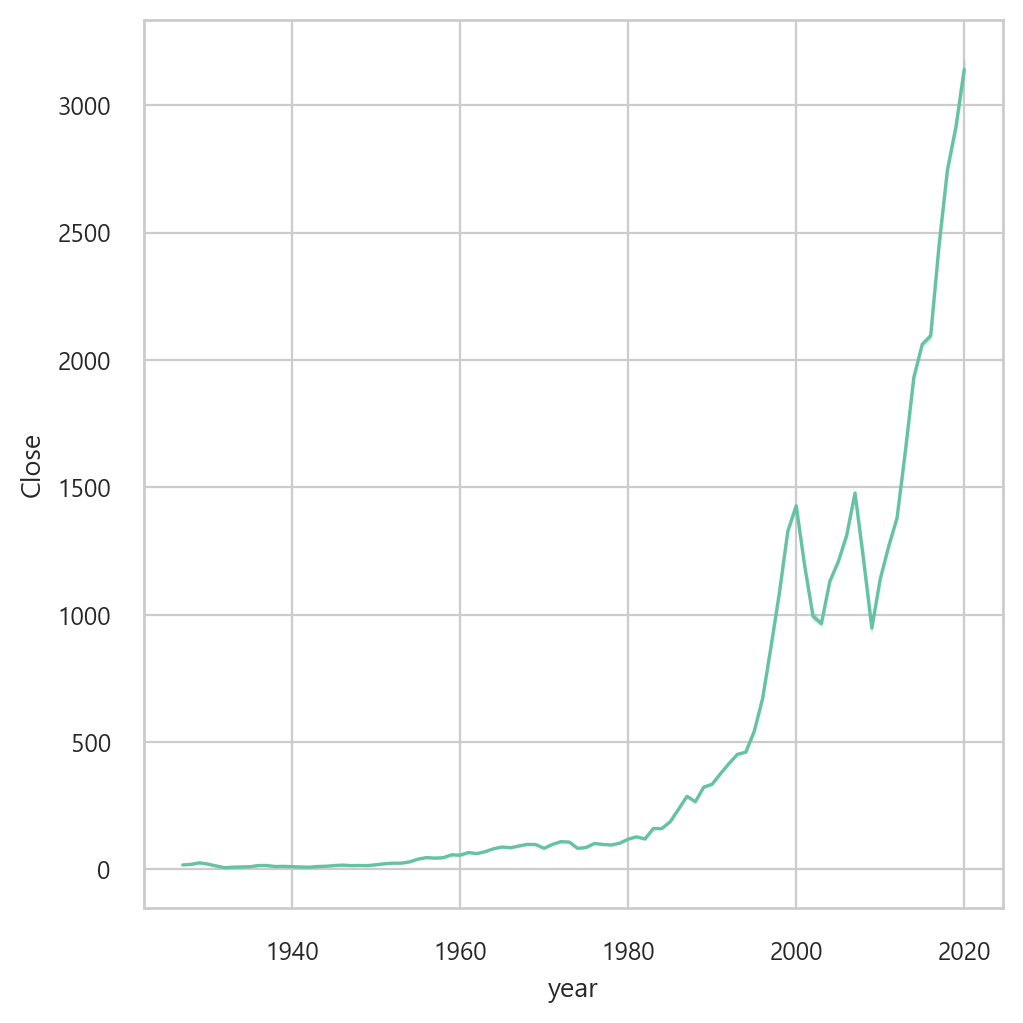

In [69]:
days_Y = pd.Series(close_snp["Date"].dt.day_of_year, name="day_of_year")
month = pd.Series(close_snp["Date"].dt.month, name="month")
week = pd.Series(close_snp["Date"].dt.day_name(), name="weeks")
diff_close = pd.Series(close_snp["Close"] - close_snp["Close"].shift(), name="diff_close")

df = pd.concat([close_snp,diff_close, days_Y,month,week],axis=1)
df["year"] = df["Date"].dt.year
df = df[["year","day_of_year","month","weeks","Close","diff_close"]]

fig, ax = plt.subplots(figsize = (5,5))
# 연도, 달, 주, 일별로 분류하고 마지막 가격으로 설정

sns.lineplot(data = df,
         x = "year",
         y = "Close",
         ax=ax);

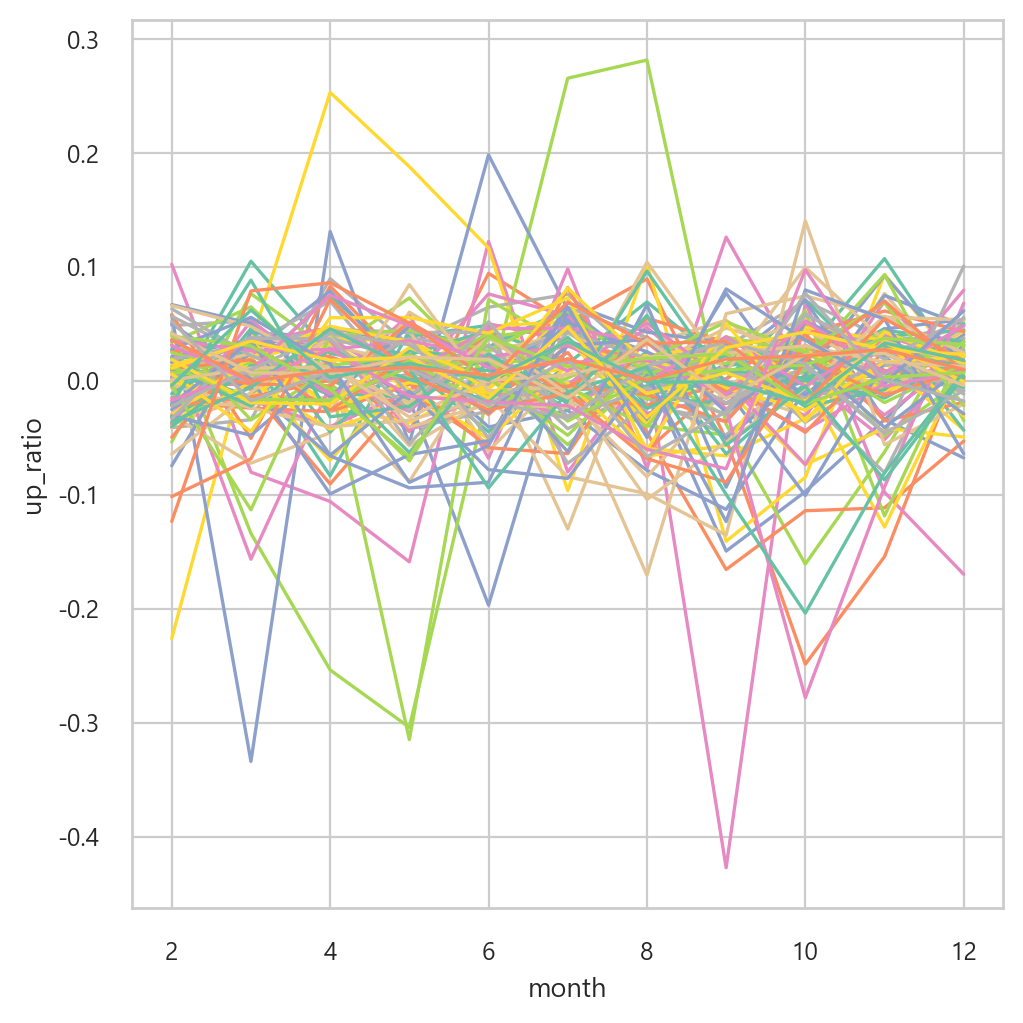

In [70]:
fig, ax = plt.subplots(figsize = (5,5))

for i in range(1928,2018):

    forgr_=df[df["year"]==i].groupby("month").last()
    forgr_["up_ratio"] = (forgr_["Close"] - forgr_["Close"].shift())/forgr_["Close"]
    sns.lineplot(data = forgr_,
             x = "month",
             y = "up_ratio",
             ax=ax);


In [71]:
fig, ax = plt.subplots(figsize = (5,5))

for i in range(1928,2005):
    for month in range(1,13):
        y_m_w = df[(df["year"] == i) & (df["month"] == month)].groupby("weeks").mean()
        y_m_w = y_m_w - y_m_w.shift()
        sns.lineplot(data=y_m_w,
                     x = "weeks",
                     y = "diff_close",
                    ax=ax);

<AxesSubplot: xlabel='day_of_year', ylabel='Close'>

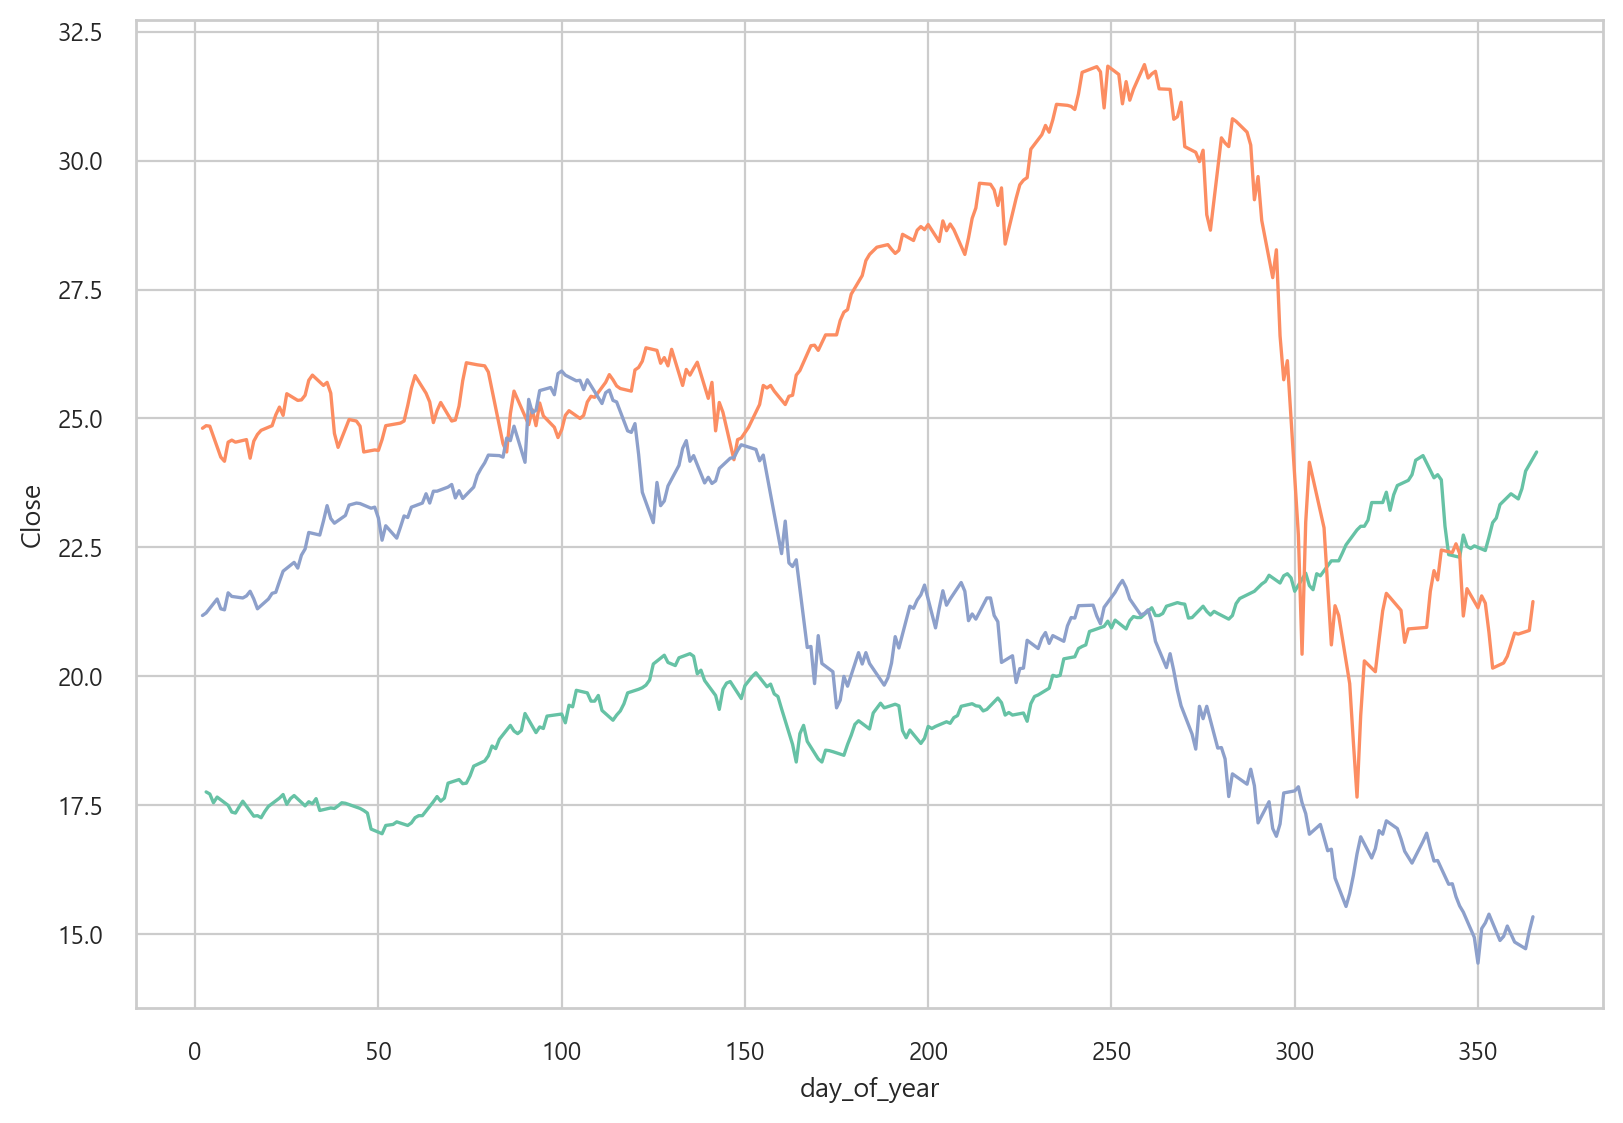

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(data=df[df["year"] == 1928],
             x="day_of_year",
             y="Close",
             ax=ax)

sns.lineplot(data=df[df["year"] == 1929],
             x="day_of_year",
             y="Close",
             ax=ax)

sns.lineplot(data=df[df["year"] == 1930],
             x="day_of_year",
             y="Close",
             ax=ax)

<AxesSubplot: xlabel='day_of_year', ylabel='Close'>

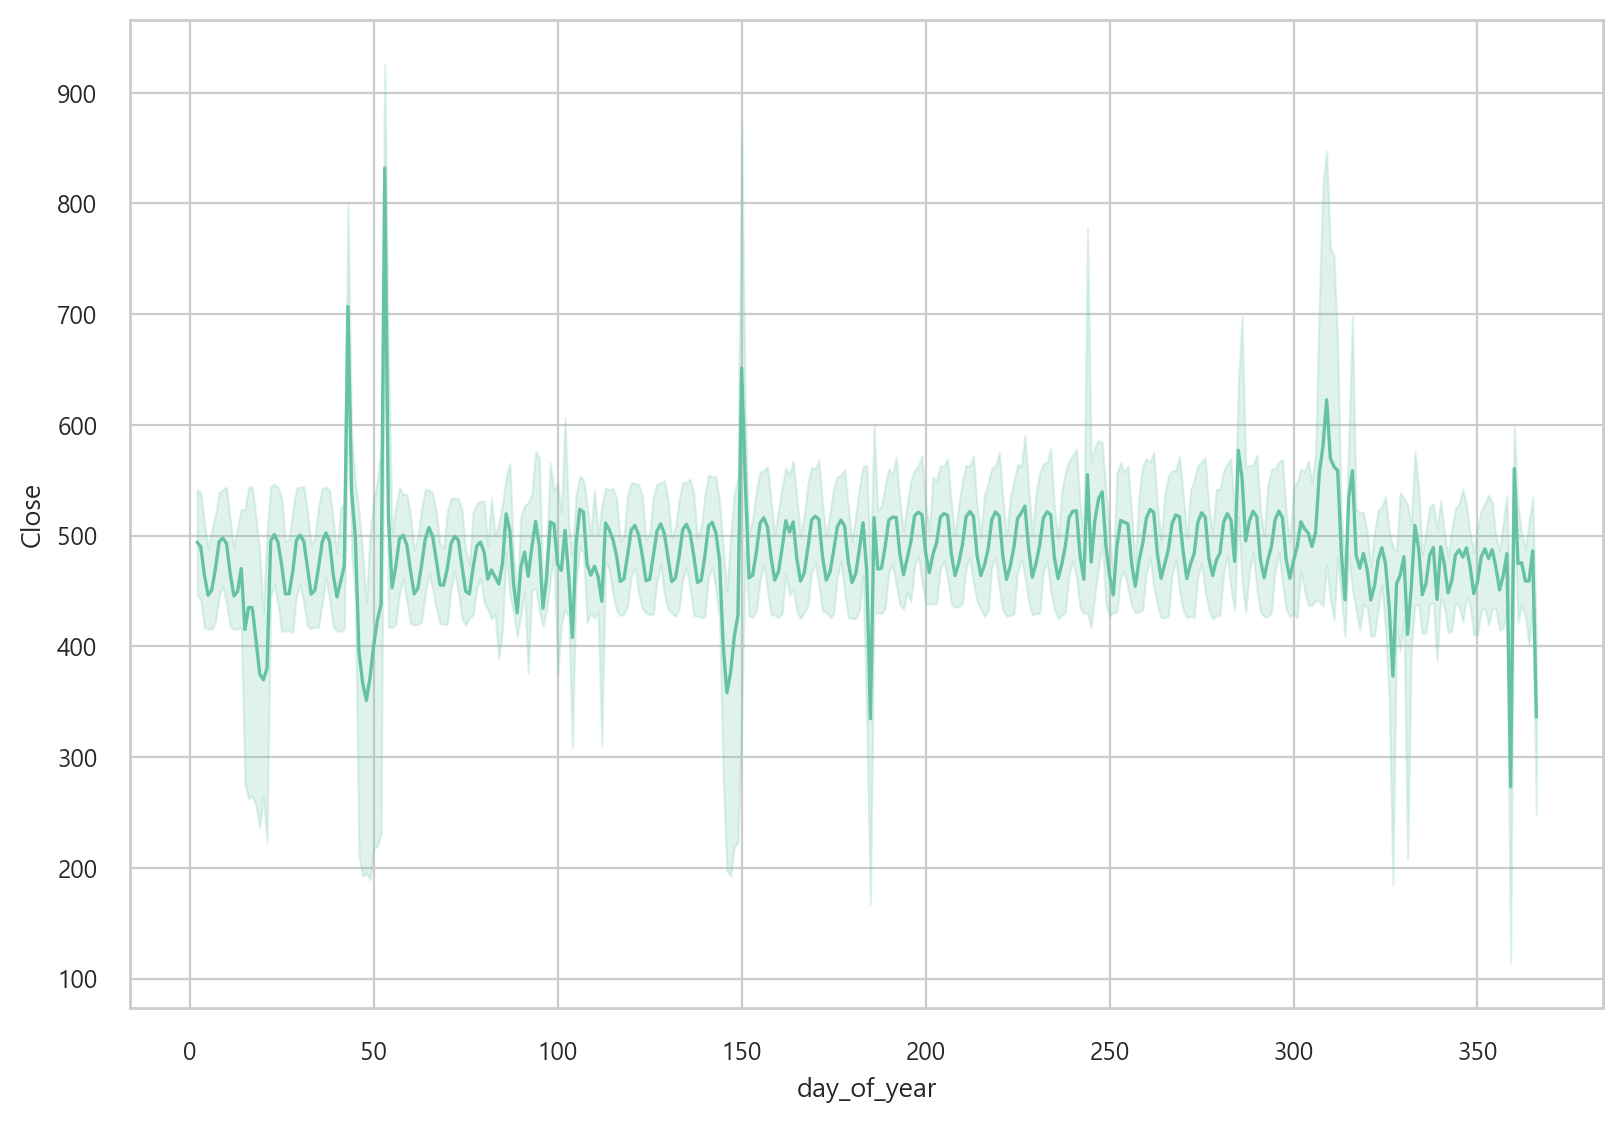

In [ ]:
days_of_y = df.groupby(["day_of_year","weeks"]).mean()

fig, ax = plt.subplots()
sns.lineplot(data=days_of_y,
             x="day_of_year",
             y="Close",
             ax=ax)

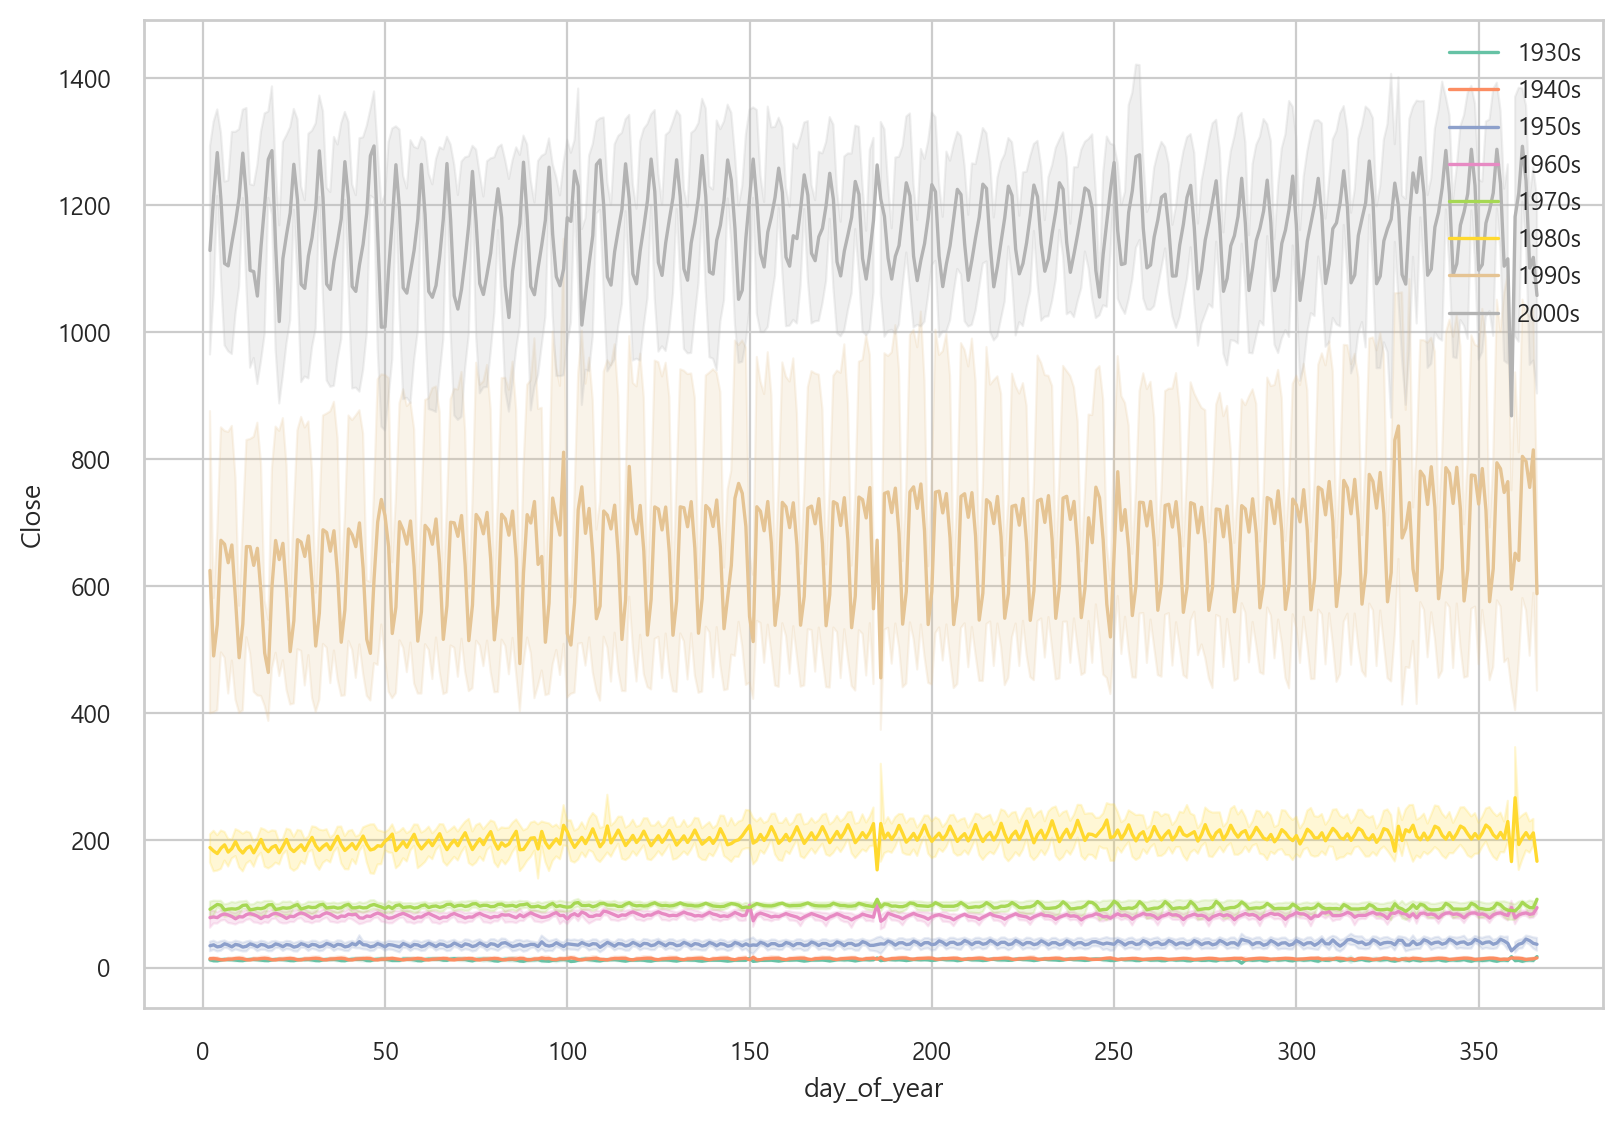

In [ ]:
fig, ax = plt.subplots()

for i in range(1930,2010,10):
    over = i < df["year"]
    under = df["year"] < i + 10

    period_df = df[over & under]
    days_of_y = period_df.groupby(["day_of_year","weeks"]).mean()

    sns.lineplot(data=days_of_y,
                 x="day_of_year",
                 y="Close",
                 label=str(i)+"s",
                 ax=ax)

<AxesSubplot: xlabel='Date', ylabel='Close'>

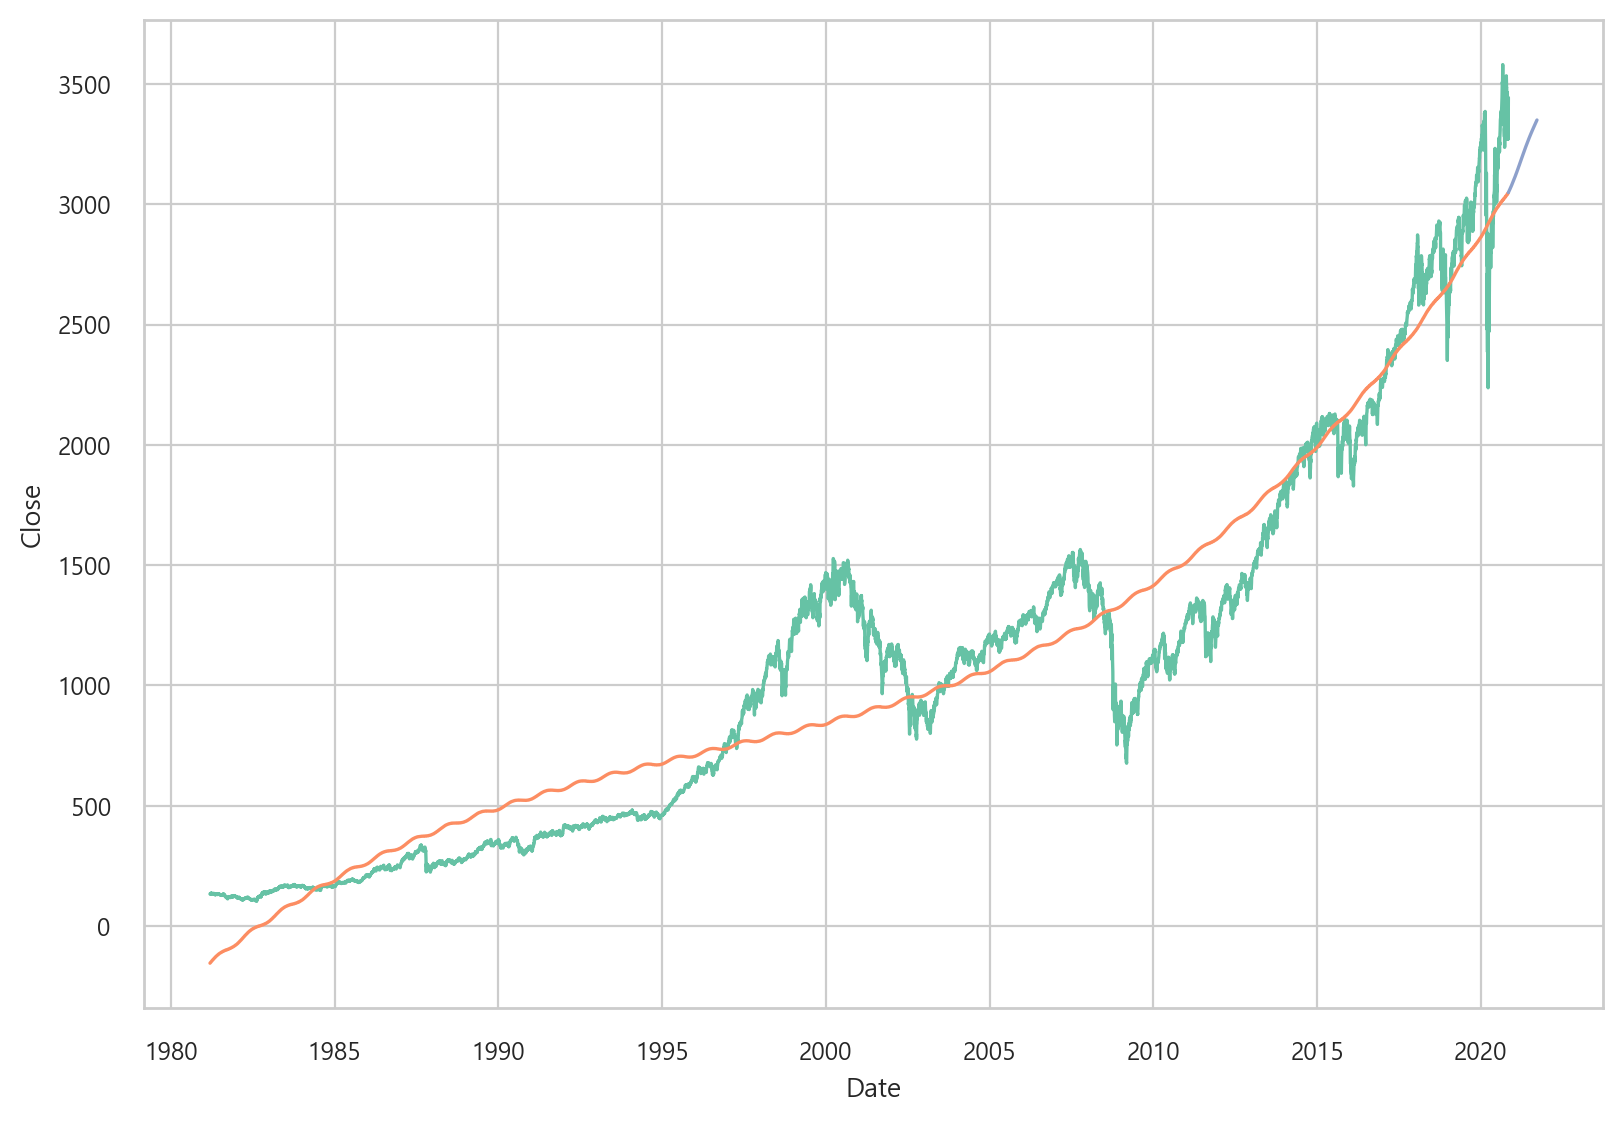

In [391]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
import pandas as pd

# 데이터 불러오기
snp_500 = pd.read_csv('../datas/study_data/snp500_history.csv',
                      parse_dates=['Date'], index_col=['Date']).tail(10000)

# Y Q W
fourier = CalendarFourier(freq="A", order=1)

dp = DeterministicProcess(
    index=snp_500.index,
    constant=True,
    order=3,
    seasonal=True,
    period=3,
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample()  # create features for dates in tunnel.index

y = snp_500["Close"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)

# Forecasting
forecast_index = pd.date_range(start=snp_500.index[-1], periods=320, freq='D')
X_fore = dp.out_of_sample(steps=320, forecast_index=forecast_index)
y_fore = pd.Series(model.predict(X_fore), index=forecast_index)

fig, ax = plt.subplots()

# Plotting
sns.lineplot(y,ax=ax)
sns.lineplot(y_pred,ax=ax)
sns.lineplot(y_fore,ax=ax)

<AxesSubplot: xlabel='Date', ylabel='Close'>

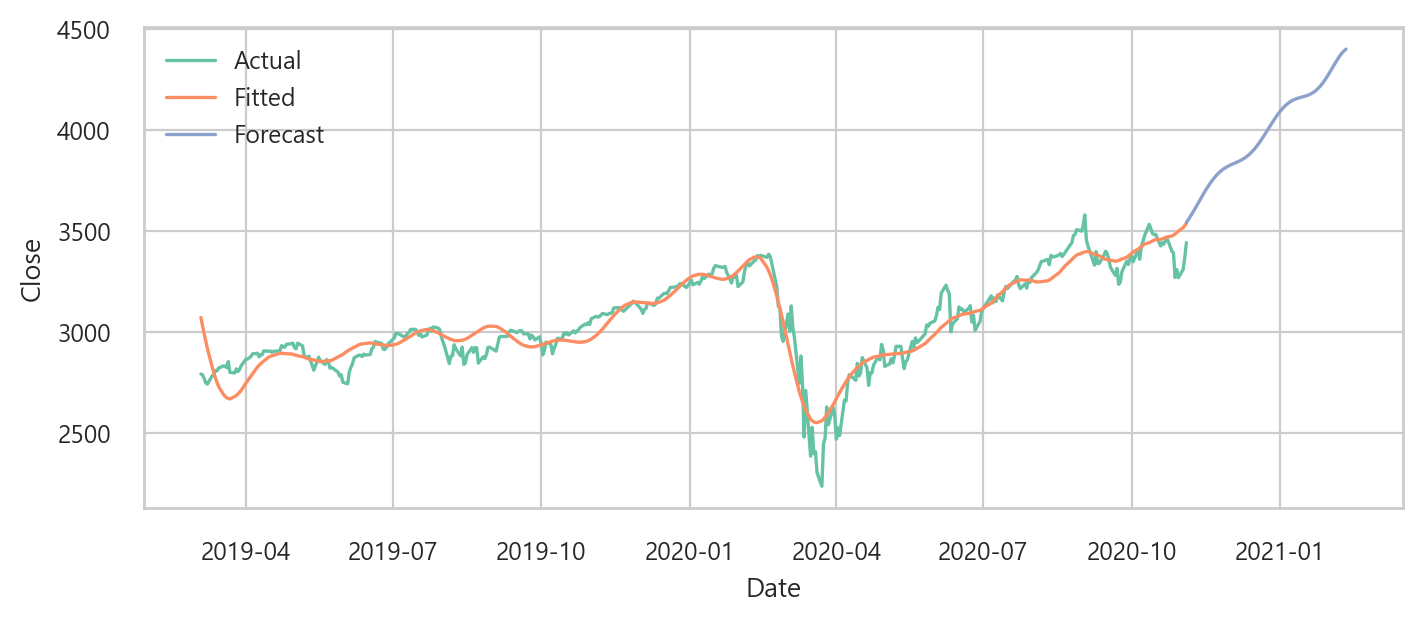

In [430]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
snp_500 = pd.read_csv('../datas/study_data/snp500_history.csv',
                      parse_dates=['Date'], index_col=['Date']).tail(425)

# 연간 주기 설정
fourier = CalendarFourier(freq="Y", order=10)

dp = DeterministicProcess(
    index=snp_500.index,
    constant=True,
    order=2,
    seasonal=False,
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample()  # 주어진 인덱스에 대해 특징 행렬 생성

y = snp_500["Close"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)

# 예측
forecast_index = pd.date_range(start=snp_500.index[-1], periods=100, freq='D')
X_fore = dp.out_of_sample(steps=100, forecast_index=forecast_index)
y_fore = pd.Series(model.predict(X_fore), index=forecast_index)

fig, ax = plt.subplots(figsize=(7, 3))

# 시각화
sns.lineplot(data=y, ax=ax, label='Actual')
sns.lineplot(data=y_pred, ax=ax, label='Fitted')
sns.lineplot(data=y_fore, ax=ax, label='Forecast')


In [431]:
X

,const,trend,trend_squared,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-04,1.0,1.0,1.0,0.875892,0.482508,0.845249,-0.534373,-0.060213,-0.998186,-0.903356,...,0.120208,0.992749,0.927542,0.373720,0.774884,-0.632103,-0.179767,-0.983709,-0.948362,-0.317191
2019-03-05,1.0,2.0,4.0,0.884068,0.467359,0.826354,-0.563151,-0.111659,-0.993747,-0.930724,...,0.221922,0.975065,0.965740,0.259512,0.680773,-0.732494,-0.329408,-0.944188,-0.988678,-0.150055
2019-03-06,1.0,3.0,9.0,0.891981,0.452072,0.806480,-0.591261,-0.162807,-0.986658,-0.953681,...,0.321270,0.946988,0.989932,0.141540,0.573772,-0.819015,-0.471160,-0.882048,-0.999769,0.021516
2019-03-07,1.0,4.0,16.0,0.899631,0.436651,0.785650,-0.618671,-0.213521,-0.976938,-0.972118,...,0.417194,0.908818,0.999769,0.021516,0.455907,-0.890028,-0.601624,-0.798779,-0.981306,0.192452
2019-03-08,1.0,5.0,25.0,0.907014,0.421101,0.763889,-0.645348,-0.263665,-0.964614,-0.985948,...,0.508671,0.860961,0.995105,-0.098820,0.329408,-0.944188,-0.717677,-0.696376,-0.933837,0.357698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-29,1.0,421.0,177241.0,-0.890617,0.454755,-0.810025,-0.586396,0.153891,-0.988088,0.949990,...,-0.304115,0.952635,-0.986731,0.162366,-0.593327,-0.804962,0.447094,-0.894487,0.999963,-0.008583
2020-10-30,1.0,422.0,178084.0,-0.882679,0.469977,-0.829677,-0.558244,0.102821,-0.994700,0.926324,...,-0.204552,0.978856,-0.960150,0.279486,-0.697944,-0.716152,0.304115,-0.952635,0.983798,-0.179281
2020-11-02,1.0,423.0,178929.0,-0.857315,0.514793,-0.882679,-0.469977,-0.051479,-0.998674,0.829677,...,0.102821,0.994700,-0.799839,0.600214,-0.926324,-0.376728,-0.153891,-0.988088,0.767880,-0.640593


In [87]:
int(snp_500.index.year.value_counts().median())

252

,Close_diff
Date,
1928-01-03,0.005631
1928-01-04,-0.002257
1928-01-05,-0.009687
1928-01-06,0.006229
1928-01-09,-0.009143
...,...
2020-10-29,0.011806
2020-10-30,-0.012278
2020-11-02,0.012168


Text(0.5, 0, 'Hz = 1/일')

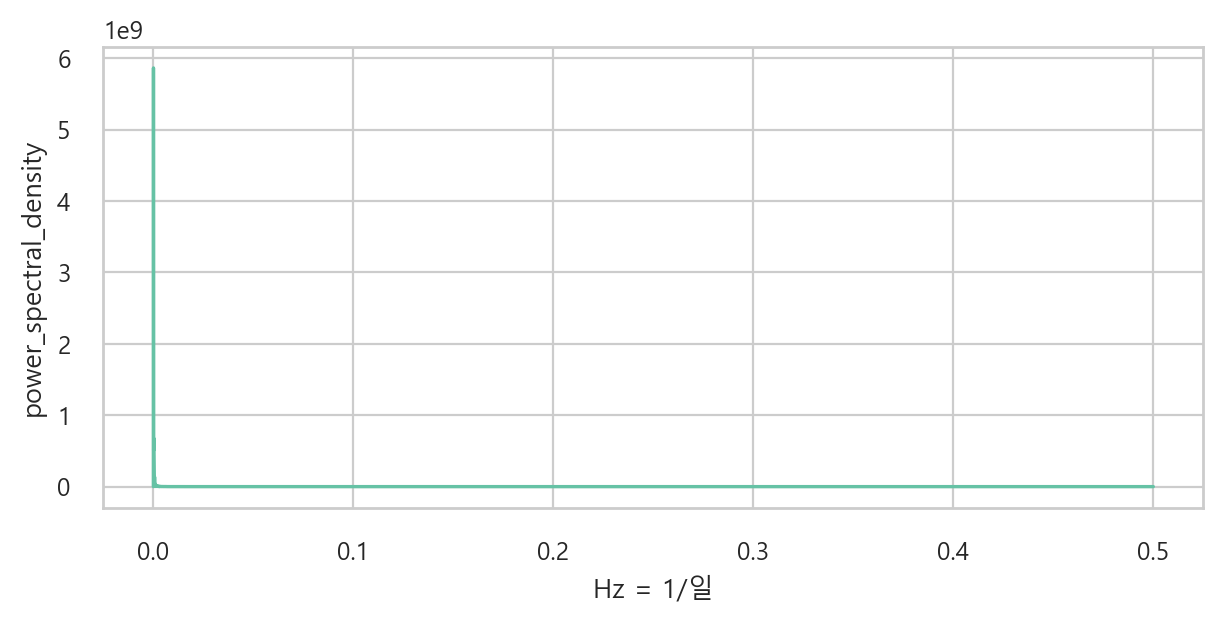

In [276]:
import pandas as pd
import numpy as np
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose



# 주식 데이터 불러오기 (예시)
snp_500 = pd.read_csv('../datas/study_data/snp500_history.csv',
                      parse_dates=['Date'],
                      index_col=['Date'])

# Periodogram 계산
frequencies, power_spectral_density = signal.periodogram(snp_500["Close"])

fig, ax = plt.subplots(1,1,figsize=(6, 3))
# Periodogram 시각화
sns.lineplot(x=frequencies,
             y=power_spectral_density,ax=ax);

plt.ylabel("power_spectral_density")
plt.xlabel("Hz = 1/일")

In [277]:
max_of_density = power_spectral_density.argmax() # 1

In [279]:
1 / frequencies[max_of_density]



23323.0

Text(0.5, 0, 'Hz = 1/일')

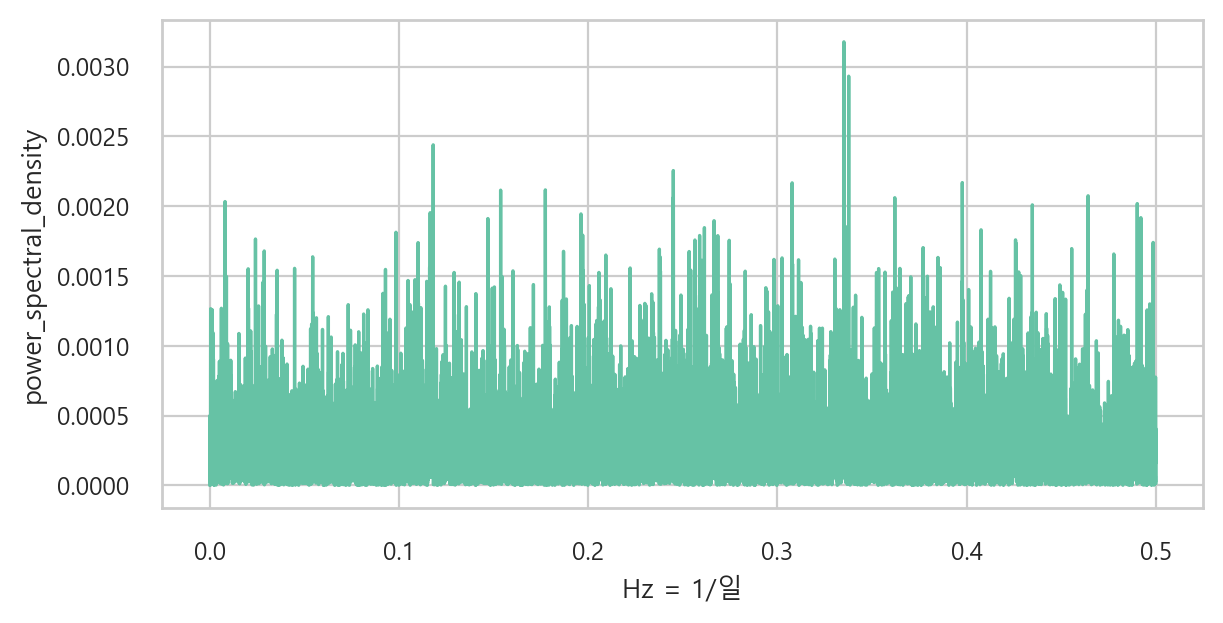

In [285]:
diff_snp = ((snp_500[["Close"]] - snp_500[["Close"]].shift())/snp_500[["Close"]]).dropna()
diff_snp.rename(columns={"Close":"Close_diff"},inplace=True)

# Periodogram 계산
frequencies, power_spectral_density = signal.periodogram(diff_snp["Close_diff"])

fig, ax = plt.subplots(1,1,figsize=(6, 3))
# Periodogram 시각화
sns.lineplot(x=frequencies,
             y=power_spectral_density,ax=ax);

plt.ylabel("power_spectral_density")
plt.xlabel("Hz = 1/일")

In [306]:
max_of_density = power_spectral_density.argmax() # 1
1 / frequencies[max_of_density]

2.2222222222222223

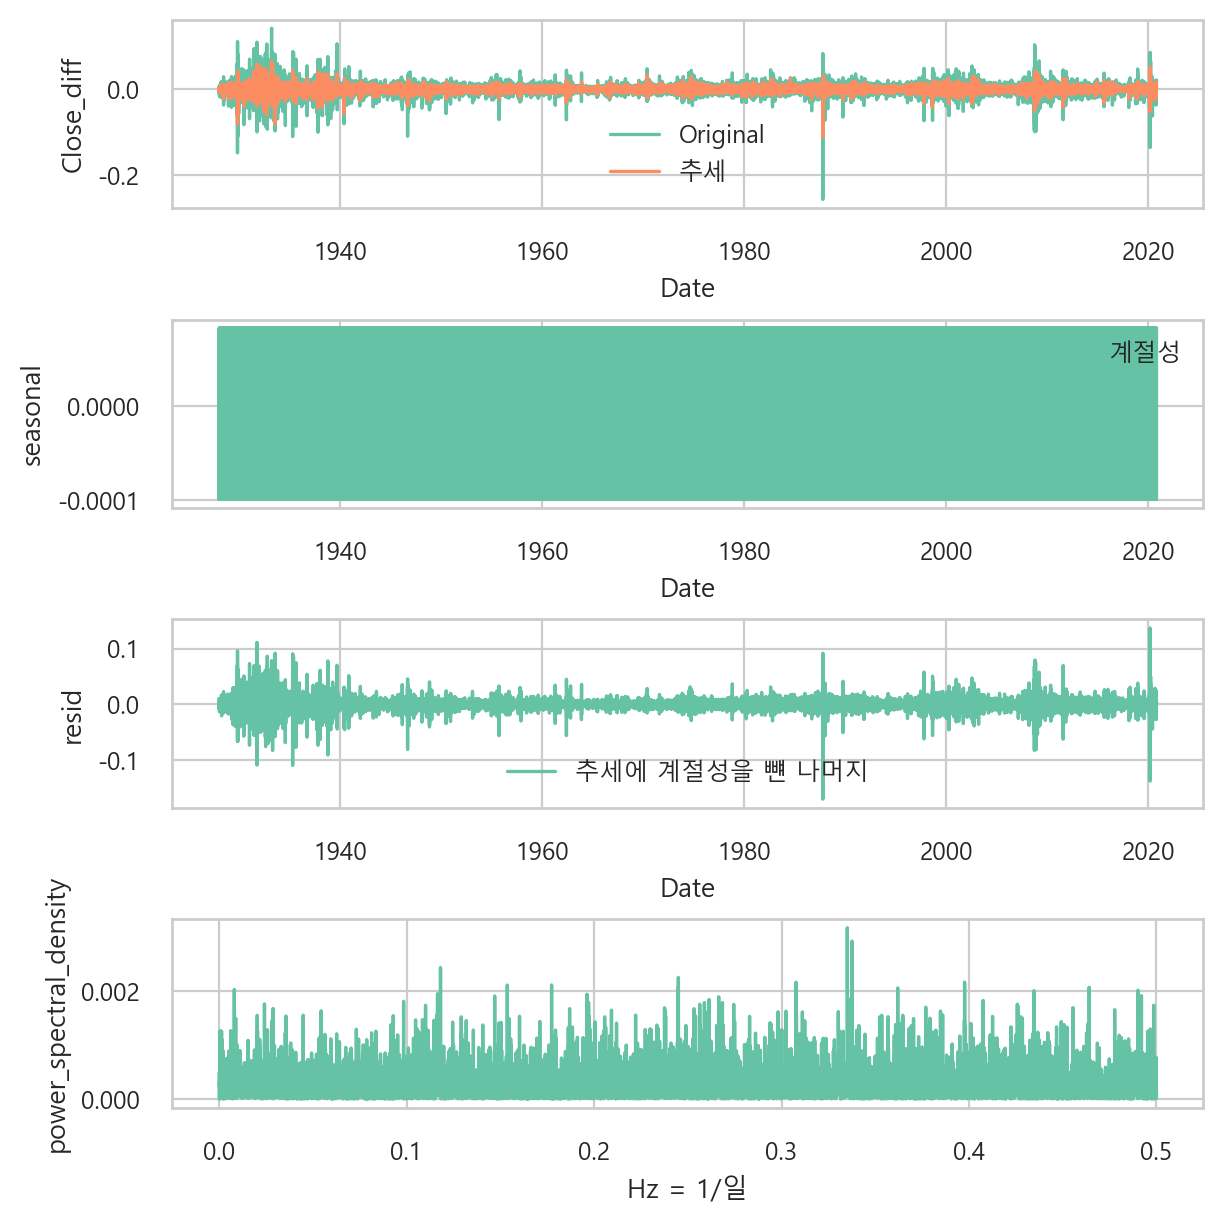

In [317]:
diff_snp_piced = diff_snp["Close_diff"] # 너무 많아서 데이터갯수를 줄였다

# 주기적인 시계열 분해를 통한 주기성 분석
decomposition = seasonal_decompose(diff_snp_piced, period=3)  # 예시로 주별 주기 설정

# 시계열 분해 결과 시각화
fig, ax = plt.subplots(4,1,figsize=(6, 6))

sns.lineplot(diff_snp_piced,label='Original',ax=ax[0])
sns.lineplot(decomposition.trend,label='추세',ax=ax[0])
sns.lineplot(decomposition.seasonal,label='계절성',ax=ax[1])
sns.lineplot(decomposition.resid,label='추세에 계절성을 뺸 나머지',ax=ax[2])

# Periodogram 계산
frequencies, power_spectral_density = signal.periodogram(diff_snp_piced)

# Periodogram 시각화
sns.lineplot(x=frequencies,
             y=power_spectral_density,ax=ax[3]);

plt.ylabel("power_spectral_density")
plt.xlabel("Hz = 1/일");

In [315]:
max_of_density = power_spectral_density.argmax() # 1
1 / frequencies[max_of_density]

2.272727272727273

In [320]:
snp_500.

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...,...
2020-10-29,3277.169922,3341.050049,3259.820068,3310.110107,3310.110107,4903070000
2020-10-30,3293.590088,3304.929932,3233.939941,3269.959961,3269.959961,4840450000
2020-11-02,3296.199951,3330.139893,3279.739990,3310.239990,3310.239990,4310590000
